# Part 7: Leveraging Neural Networks for SoC estimation

Instead of learning precise dynamics terms, such as those with DMD and SINDy, we may think of representing battery dynamics with a Neural Network. Alternatively, we may think of using a Neural Network as an estimator of the state-of-charge (or Ampere-hours discharged $d$). 
In this tutorial, we will work with the latter scenario where we will create a feed-forward neural network for SoC estimation, train the network, and use it with Collimator.

## Dataset
We utilise the same dataset as in the previous tutorial. We also resample the dataset at a frequency of 10Hz. Contrary to previous tutorials, we swap the training and validation files. This is because the Mixed cycle, containing data for a variety of drive cycles, is a better dataset for training the neural network as it shows many drive-cycle variations.

## Neural Network

Through an NN, we will seek an $d$ estimator of the following form:

\begin{align}
d[k] = f_{\text{NN}}(v_t[k], i[k]),
\end{align}

where $f_{\text{NN}}$ is a neural network that predicts the Ampere-hours discharged $d[k]$, given the measurements of terminal voltage $v_t[k]$ and discharge current $i[k]$.

Recall that $d[k]$ is related to SoC $s$ algebraically as $s[k] = \dfrac{Q-d[k]}{Q}$, where $Q$ is the battery capacity. 

The particular form for NN will be a simple multi-layer perceptron (MLP).

In [1]:
%matplotlib inline

from math import ceil
import matplotlib.pyplot as plt
import os
import time
import warnings

import numpy as np

import jax
import jax.numpy as jnp
import optax
from scipy.io import loadmat

warnings.filterwarnings("ignore", category=FutureWarning)

# As this notebook is executed in CI, reduce the number of epochs of training to speed up testing
CI = os.environ.get("CI", "false").lower() == "true"

val_file_name = "dataset_25deg/10-28-18_17.44 551_UDDS_25degC_LGHG2.mat"
train_file_name = "dataset_25deg/10-29-18_14.41 551_Mixed1_25degC_LGHG2.mat"

tain_data = loadmat(train_file_name)
val_data = loadmat(val_file_name)

Q = 3.0  # battery capacity is known to be 3Ah (LG HG2 cell)


def extract_features_from_matfile(filename, Q=3.0, dt=0.1):
    data = loadmat(filename)
    t = data["meas"][0][0][0]
    vt = data["meas"][0][0][2]
    curr = -data["meas"][0][0][3]
    D = -data["meas"][0][0][4]

    # Resample
    T_end = t[-1, 0]
    t_resampled = np.linspace(0.0, T_end, ceil(T_end / dt))
    vt_resampled = np.interp(t_resampled, t[:, 0], vt[:, 0])
    curr_resampled = np.interp(t_resampled, t[:, 0], curr[:, 0])
    D_resampled = np.interp(t_resampled, t[:, 0], D[:, 0])

    return (t_resampled, vt_resampled, curr_resampled, D_resampled)


t_train, vt_train, curr_train, d_train = extract_features_from_matfile(train_file_name)
t_val, vt_val, curr_val, d_val = extract_features_from_matfile(val_file_name)

Collimator has native support for MLPs through the `collimator.library.MLP` block. For training the MLP, we will use the `optax` library.

In [2]:
import collimator
from collimator.framework import LeafSystem, parameters
from collimator.library import MLP, Multiplexer, Adder, Power, IntegratorDiscrete, Integrator, Gain, Demultiplexer
from collimator.simulation import SimulatorOptions, ODESolverOptions

from typing import NamedTuple

We start by creating the MLP config (similar to the MLP configuration in the `equinox` library), and passing it to the `collimator.library.MLP` block for creating and initializing the MLP.

In [3]:
config = {
    "in_size":2,  # dimension of input = [v[k], i[k]]
    "out_size":1, # dimension of output = [d[k]]
    "width_size":128, # width of every hidden layer
    "depth":2, # number of hidden layers, including output layer
    "activation_str":"relu", # string represenging activation funcition after each internal layer
    "seed": 42, # seed for initialization of the weigths and biases
}

model = MLP(**config, name="mlp")

The above `model` will have one vector-valued input port (representing the MLP inputs) and one vector-valued output port (representing the output of the MLP). 

To evaluate the `model` for a given input, we need to first fix the value of its input port to the given input, and then evaluate the output port. This is achieved with the `evaluate_model` below, which also includes the `mlp_params` argument for us to vary the `mlp_params`.

In [4]:
# create a base context that can be modified later
with model.input_ports[0].fixed(jnp.zeros(2)):
    base_context = model.create_context()

# Function to evaluate the output of the MLP given MLP params and input x
def evaluate_model(x, mlp_params, base_context):
    context = base_context.with_parameter("mlp_params", mlp_params)
    with model.input_ports[0].fixed(x):
        y = model.output_ports[0].eval(context) # vector
    return y[0] # return the first/only element of the vector as a scalar

The call to `MLP` above initializes the MLP parameters randomly based on the provided `seed`. We can get these initial parameters from the context.

In [5]:
initial_mlp_params = base_context.parameters["mlp_params"]

With these parameters, we can evaluate the output of the MLP for any input.

In [6]:
sample_input = jnp.array([0.5, 0.3])
evaluate_model(sample_input, initial_mlp_params, base_context)

Array(0.01740814, dtype=float64)

To evaluate the model over a set of inputs, we can utilize the `jax.vmap` utility as shown below. Subsequently, we can write a `loss` function, which evaluates the mean-squared error over a set of inputs `train_x` and data `train_y`.

In [7]:
evaluate_model_vmapped = jax.vmap(evaluate_model, in_axes=(0, None, None))

def loss(mlp_params, train_x, train_y, base_context):
    pred_y = evaluate_model_vmapped(train_x, mlp_params, base_context)
    return jnp.mean((pred_y - train_y)**2)

With the above `loss` function, we can now train the MLP, i.e. find a set of optmial MLP parameters that minimize the `loss` function. We can achieve this with the `optax` library. In what follows, we use tha ADAM method.

Epoch [30/300]: train loss = 0.764303, test loss = 0.690553, elapsed time = 12.590 sec
Epoch [60/300]: train loss = 0.740561, test loss = 0.671219, elapsed time = 11.202 sec
Epoch [90/300]: train loss = 0.707351, test loss = 0.645913, elapsed time = 9.478 sec
Epoch [120/300]: train loss = 0.642105, test loss = 0.598038, elapsed time = 9.547 sec
Epoch [150/300]: train loss = 0.412717, test loss = 0.404549, elapsed time = 10.117 sec
Epoch [180/300]: train loss = 0.038306, test loss = 0.041162, elapsed time = 10.640 sec
Epoch [210/300]: train loss = 0.016660, test loss = 0.014908, elapsed time = 9.676 sec
Epoch [240/300]: train loss = 0.016185, test loss = 0.012967, elapsed time = 10.116 sec
Epoch [270/300]: train loss = 0.017702, test loss = 0.012328, elapsed time = 10.231 sec
Epoch [300/300]: train loss = 0.012925, test loss = 0.019371, elapsed time = 9.830 sec


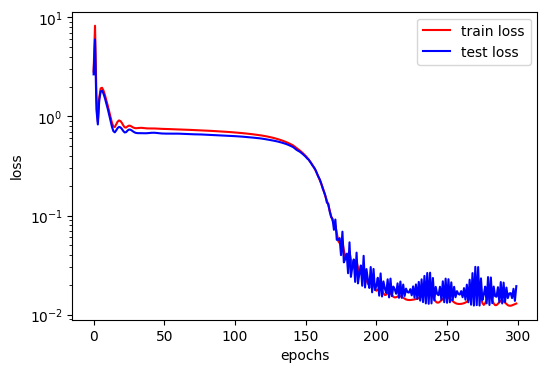

In [8]:
train_x = np.vstack([vt_train, curr_train]).T # training input
train_y = d_train # training output

test_x = np.vstack([vt_val, curr_val]).T # testing input
test_y = d_val # testing output

# create a jit compiled function to compute the loss value and gradients via autodiff
value_and_grad = jax.jit(jax.value_and_grad(loss))

# Optax optimizer
optimizer = optax.adam(learning_rate=0.01)

# Initialize optimizer state
params = initial_mlp_params
opt_state = optimizer.init(params)

num_epochs = 300 if not CI else 2

train_loss_history = []
test_loss_history = []
interval_ts = time.time()
for epoch in range(num_epochs):
    train_loss, grads = value_and_grad(params, train_x, train_y, base_context)
    test_loss = loss(params, test_x, test_y, base_context)

    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)

    # Print the function value at the current parameters
    if (epoch + 1) % 30 == 0:
        elapsed_time = time.time() - interval_ts
        print(
            f"Epoch [{epoch+1}/{num_epochs}]: train loss = {train_loss:.6f}, "
            f"test loss = {test_loss:.6f}, elapsed time = {elapsed_time:.3f} sec"
        )
        interval_ts = time.time()

fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(train_loss_history, "-r", label="train loss")
ax.plot(test_loss_history, "-b", label="test loss")
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.set_yscale("log")
ax.legend()
plt.show()

Next, we can visualize the MLP predictions on the training and testing data.

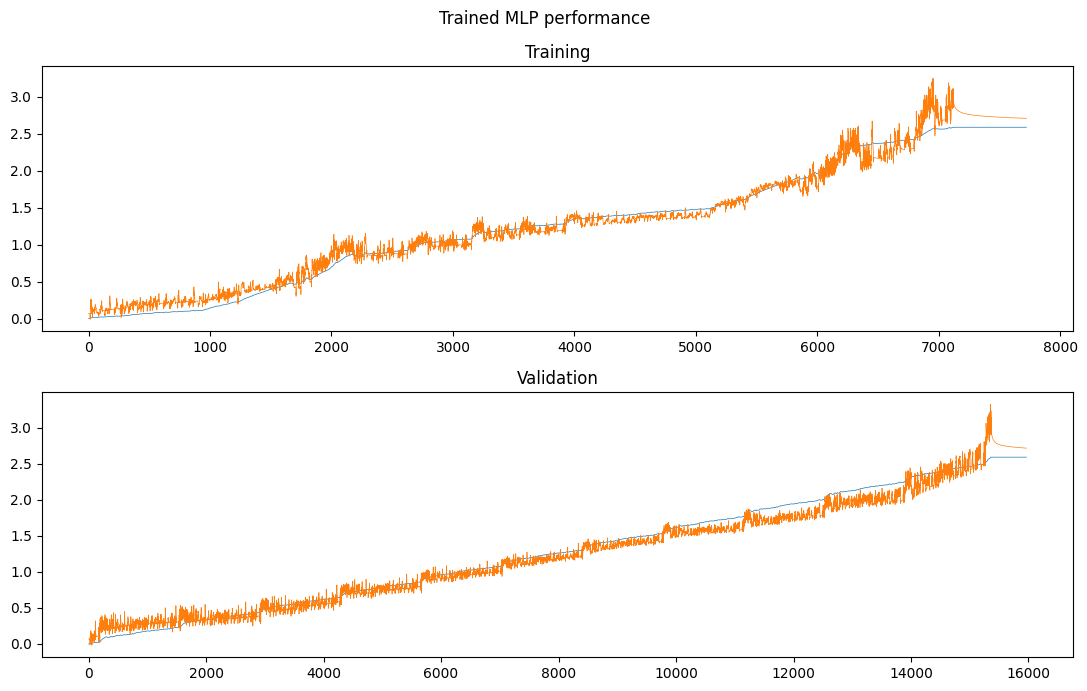

In [9]:
pred_train = evaluate_model_vmapped(train_x, params, base_context)
pred_test = evaluate_model_vmapped(test_x, params, base_context)

lw=0.5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 7))
ax1.plot(t_train, train_y, label=r"$d$: exp", lw=lw)
ax1.plot(t_train, pred_train, label=r"$d$: MLP", lw=lw)
ax1.set_title("Training")

ax2.plot(t_val, test_y, label=r"$d$: exp", lw=lw)
ax2.plot(t_val, pred_test, label=r"$d$: MLP", lw=lw)
ax2.set_title("Validation")

fig.suptitle("Trained MLP performance")
fig.tight_layout()
ax.legend()
plt.show()

## Filtered features
We can train the network longer with a smaller learning rate to improve performance or change the architecture in terms of hidden layer sizes and depth. However, we note that the MLP predictions are rather noisy. This phenomenon has been reported in the [literature](https://doi.org/10.1016/j.est.2021.103660), and it has been suggested to use filtered waveforms for the input current and voltages. In particular, it has been suggested that two first-order Butterworth filters with cutoff frequencies 0.5 mHz and 5 mHz be utilised. Let's try this approach

In [10]:
from scipy.signal import butter, filtfilt


def butterworth_filter(time_series, cutoff_freq, sampling_rate, order=1):
    """
    Apply a Butterworth filter to a time-series data.

    Parameters:
    time_series (array-like): The input time-series data.
    cutoff_freq (float): The cutoff frequency of the filter in Hz.
    sampling_rate (float): The sampling rate of the time-series data in Hz.
    order (int): The order of the filter. Default is 1.

    Returns:
    array-like: Filtered time-series data.
    """
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    filtered_data = filtfilt(b, a, time_series)
    return filtered_data


Ts = 0.1  # We resampled the original dataset with this timestep.
fc1 = 5e-04  # 0.5 mHz cutoff frequency
fc2 = 5e-03  # 5 mHz cutoff frequency

# Training features
vt_f1_train = butterworth_filter(vt_train, fc1, 1.0 / Ts, order=1)
vt_f2_train = butterworth_filter(vt_train, fc2, 1.0 / Ts, order=1)

curr_f1_train = butterworth_filter(curr_train, fc1, 1.0 / Ts, order=1)
curr_f2_train = butterworth_filter(curr_train, fc2, 1.0 / Ts, order=1)

# Testing features
vt_f1_val = butterworth_filter(vt_val, fc1, 1.0 / Ts, order=1)
vt_f2_val = butterworth_filter(vt_val, fc2, 1.0 / Ts, order=1)

curr_f1_val = butterworth_filter(curr_val, fc1, 1.0 / Ts, order=1)
curr_f2_val = butterworth_filter(curr_val, fc2, 1.0 / Ts, order=1)

and retrain the MLP with the new features (since the input size has increased, we also increase the hidden layer sizes; the MLP architecture can be experimented with)

In [11]:
config = {
    "in_size":4,  # [vt_f1[k], vt_f2[k], curr_f1, curr_f2]
    "out_size":1, # [d[k]]
    "width_size":256,
    "depth":2,
    "activation_str":"relu",
    "seed": 42,
}

In [12]:
model = MLP(**config, name="mlp")

# create a base context that can be modified later
with model.input_ports[0].fixed(jnp.zeros(4)):
    base_context = model.create_context()

# Function to evaluate the output of the MLP given MLP params and input x
def evaluate_model(x, mlp_params, base_context):
    context = base_context.with_parameter("mlp_params", mlp_params)
    with model.input_ports[0].fixed(x):
        y = model.output_ports[0].eval(context)
    return y[0]

evaluate_model_vmapped = jax.vmap(evaluate_model, in_axes=(0, None, None))

def loss(mlp_params, train_x, train_y, base_context):
    pred_y = evaluate_model_vmapped(train_x, mlp_params, base_context)
    return jnp.mean((pred_y - train_y)**2)

In [13]:
train_x = jnp.vstack((vt_f1_train, vt_f2_train, curr_f1_train, curr_f2_train)).T
train_y = d_train

test_x = np.vstack((vt_f1_val, vt_f2_val, curr_f1_val, curr_f2_val)).T
test_y = d_val


value_and_grad = jax.jit(jax.value_and_grad(loss))

# Optax optimizer
optimizer = optax.adam(learning_rate=0.01)

# Initialize optimizer state
params = base_context.parameters["mlp_params"]
opt_state = optimizer.init(params)

num_epochs = 500 if not CI else 2

interval_ts = time.time()
for epoch in range(num_epochs):
    train_loss, grads = value_and_grad(params, train_x, train_y, base_context)
    test_loss = loss(params, test_x, test_y, base_context)

    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    # Print the function value at the current parameters
    if (epoch + 1) % 50 == 0:
        elapsed_time = time.time() - interval_ts
        print(
            f"Epoch [{epoch+1}/{num_epochs}]: train loss = {train_loss:.6f}, test "
            f"loss = {test_loss:.6f}, elapsed time: {elapsed_time:.3f} sec"
        )
        interval_ts = time.time()

opt_params = params

Epoch [50/500]: train loss = 0.688315, test loss = 0.670447, elapsed time: 34.023 sec
Epoch [100/500]: train loss = 0.137801, test loss = 0.324882, elapsed time: 32.744 sec
Epoch [150/500]: train loss = 0.009197, test loss = 0.031166, elapsed time: 32.628 sec
Epoch [200/500]: train loss = 0.026708, test loss = 0.052163, elapsed time: 32.355 sec
Epoch [250/500]: train loss = 0.002152, test loss = 0.005997, elapsed time: 32.176 sec
Epoch [300/500]: train loss = 0.003759, test loss = 0.010722, elapsed time: 32.461 sec
Epoch [350/500]: train loss = 0.003227, test loss = 0.013267, elapsed time: 32.633 sec
Epoch [400/500]: train loss = 0.000995, test loss = 0.005125, elapsed time: 32.489 sec
Epoch [450/500]: train loss = 0.019445, test loss = 0.030499, elapsed time: 32.395 sec
Epoch [500/500]: train loss = 0.002156, test loss = 0.009837, elapsed time: 32.300 sec


As before, we can visualize the performance on train and test data.

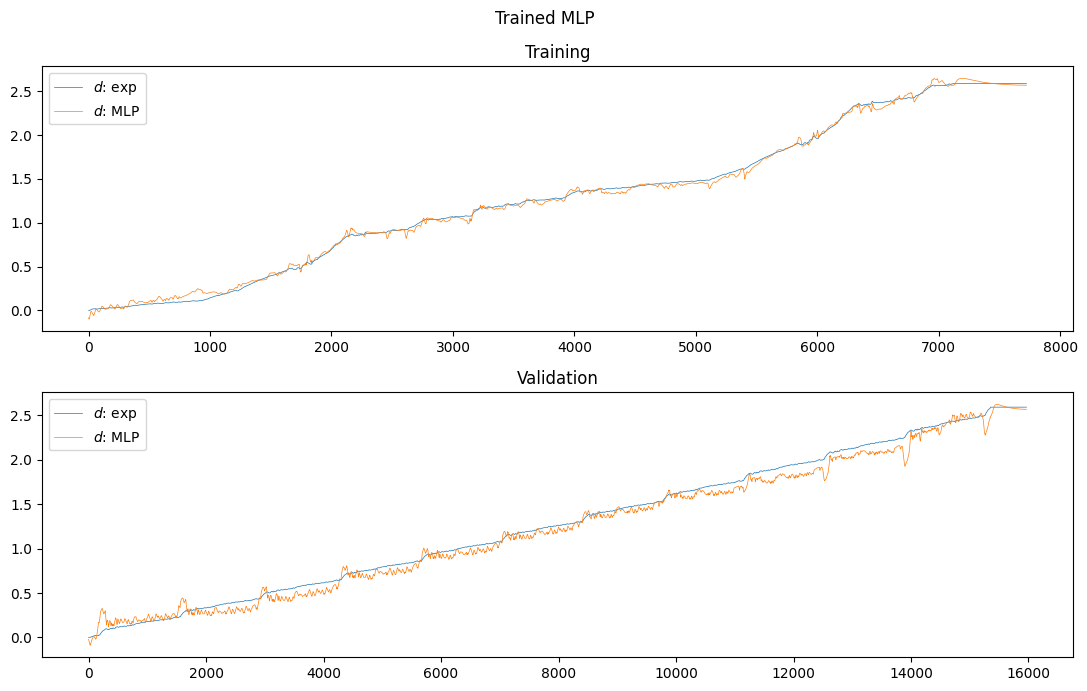

In [14]:
pred_train = evaluate_model_vmapped(train_x, params, base_context)
pred_test = evaluate_model_vmapped(test_x, params, base_context)

lw=0.5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 7))
ax1.plot(t_train, train_y, label=r"$d$: exp", lw=lw)
ax1.plot(t_train, pred_train, label=r"$d$: MLP", lw=lw)
ax1.legend()
ax1.set_title("Training")

ax2.plot(t_val, test_y, label=r"$d$: exp", lw=lw)
ax2.plot(t_val, pred_test, label=r"$d$: MLP", lw=lw)
ax2.legend()
ax2.set_title("Validation")

fig.suptitle("Trained MLP")
fig.tight_layout()
ax.legend()
plt.show()

The model is comparatively smoother predictions. Model accuracy and removal of the apparent bias in the validation data may be achieved by tuning the MLP architecture and/or considering other NN architectures. 

## Including the MLP in a wider Collimator diagram

During training, we made predictions for the entire input and test series at once. However, as part of a wider battery management system, our MLP block is likely to be used as part of a dynamical system, where, as time marches the inputs are fed to the MLP block for SoC estimation. Achieving this is easy enough and similar to the previous tutorials in this series. We can test this by including a `DiscreteSource` block as in previous tutorials, which sequentially produces the inputs for the MLP block. This exercise will also demonstrate how one can transfer the trained model parameters from one MLP block to another.

Note: we work with the filtered signals in the Collimator implementation here. However, one could work with the raw signals and filter them within the Collimator model by specifying the transfer-function of the filters and using the `TransferFunction` block available in the Collimator library.

In [15]:
class DiscreteSource(LeafSystem):
    class DiscreteStateType(NamedTuple):
        index: jnp.int64
        source_val: jnp.float64

    @parameters(dynamic=["val_array"])
    def __init__(self, val_array, dt, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.dt = dt

        self.declare_discrete_state(
            default_value=self.DiscreteStateType(index=0, source_val=val_array[0]),
            as_array=False,
        )

        self.declare_periodic_update(
            self._update,
            period=self.dt,
            offset=0,
        )

        self.declare_output_port(
            self._compute_output,
            default_value=val_array[0],
            period=self.dt,
            offset=0.0,
            requires_inputs = False,
        )

    def _compute_output(self, time, state, **params):
        return state.discrete_state.source_val

    def _update(self, time, state, *inputs, **params):
        index = state.discrete_state.index
        index = index + 1
        source_val = params["val_array"][index]
        return self.DiscreteStateType(index=index, source_val=source_val)

In [16]:
builder = collimator.DiagramBuilder()

dt = 0.1

# Create the MLP block in Collimator
mlp = builder.add(MLP(**config, name="mlp"))

# Add the input blocks as Discrete sources
vt_f1 = builder.add(DiscreteSource(jnp.array(vt_f1_train), dt=dt, name="vt_f1"))
vt_f2 = builder.add(DiscreteSource(jnp.array(vt_f2_train), dt=dt, name="vt_f2"))

curr_f1 = builder.add(DiscreteSource(jnp.array(curr_f1_train), dt=dt, name="curr_f1"))
curr_f2 = builder.add(DiscreteSource(jnp.array(curr_f2_train), dt=dt, name="curr_f2"))

# Add the multiplexer block to combine all the inputs prior to feeding the MLP
mux = builder.add(Multiplexer(4, name="mux"))

# Wire up the diagram
builder.connect(vt_f1.output_ports[0], mux.input_ports[0])
builder.connect(vt_f2.output_ports[0], mux.input_ports[1])
builder.connect(curr_f1.output_ports[0], mux.input_ports[2])
builder.connect(curr_f2.output_ports[0], mux.input_ports[3])

builder.connect(mux.output_ports[0], mlp.input_ports[0])

## build diagram and context
diagram = builder.build()
context = diagram.create_context()

# Update the mlp context to the trained parameters
opt_subcontext = context[diagram["mlp"].system_id].with_parameter("mlp_params", opt_params)
context = context.with_subcontext(diagram["mlp"].system_id, opt_subcontext)

recorded_signals = {"d": diagram["mlp"].output_ports[0]}

options = SimulatorOptions(max_major_steps=ceil(t_train[-1] / dt))
sol = collimator.simulate(
    diagram,
    context,
    (0.0, t_train[-1]),
    options=options,
    recorded_signals=recorded_signals,
)

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=77225, ode_solver_method=auto, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=1, return_context=True), Dopri5Solver(system=Diagram(root, 6 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='auto', enable_autodiff=False, supports_mass_matrix=False)


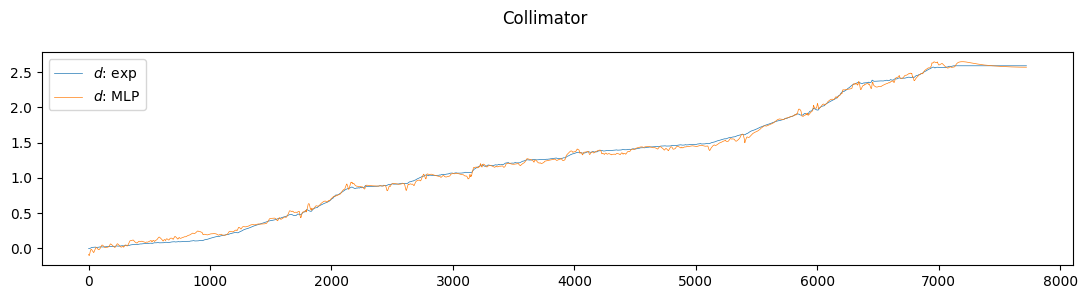

In [17]:
fig, ax = plt.subplots(figsize=(11, 3))
ax.plot(t_train, train_y, label=r"$d$: exp", lw=lw)
ax.plot(sol.time, sol.outputs["d"][:, 0], label=r"$d$: MLP", lw=lw)
fig.suptitle("Collimator")
fig.tight_layout()
ax.legend()
plt.show()